In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train.csv
/kaggle/input/colored_images/Mild/f481f76a6b75.png
/kaggle/input/colored_images/Mild/abdb365cacbc.png
/kaggle/input/colored_images/Mild/33ffddea8c6e.png
/kaggle/input/colored_images/Mild/059bc89df7f4.png
/kaggle/input/colored_images/Mild/278aa860dffd.png
/kaggle/input/colored_images/Mild/d66b6f333dc7.png
/kaggle/input/colored_images/Mild/a8c950a99107.png
/kaggle/input/colored_images/Mild/cab3dfa7962d.png
/kaggle/input/colored_images/Mild/63363410389a.png
/kaggle/input/colored_images/Mild/4da2961e62fe.png
/kaggle/input/colored_images/Mild/22098b1fe461.png
/kaggle/input/colored_images/Mild/e9286ddf6ffe.png
/kaggle/input/colored_images/Mild/4c129470cec4.png
/kaggle/input/colored_images/Mild/6b07971c3bf6.png
/kaggle/input/colored_images/Mild/b1197f2cc9b3.png
/kaggle/input/colored_images/Mild/90c982cc2d96.png
/kaggle/input/colored_images/Mild/58184d6fd087.png
/kaggle/input/colored_images/Mild/2a8a9e957a6c.png
/kaggle/input/colored_images/Mild/76be29bb30b2.png
/kaggle

In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-06-02 16:05:48.676840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748880348.876417      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748880348.935871      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Atur path ke dataset
dataset_path = "/kaggle/input/colored_images"


In [4]:
print(os.listdir(dataset_path))

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']


# **Melihat Semua Kelas** 

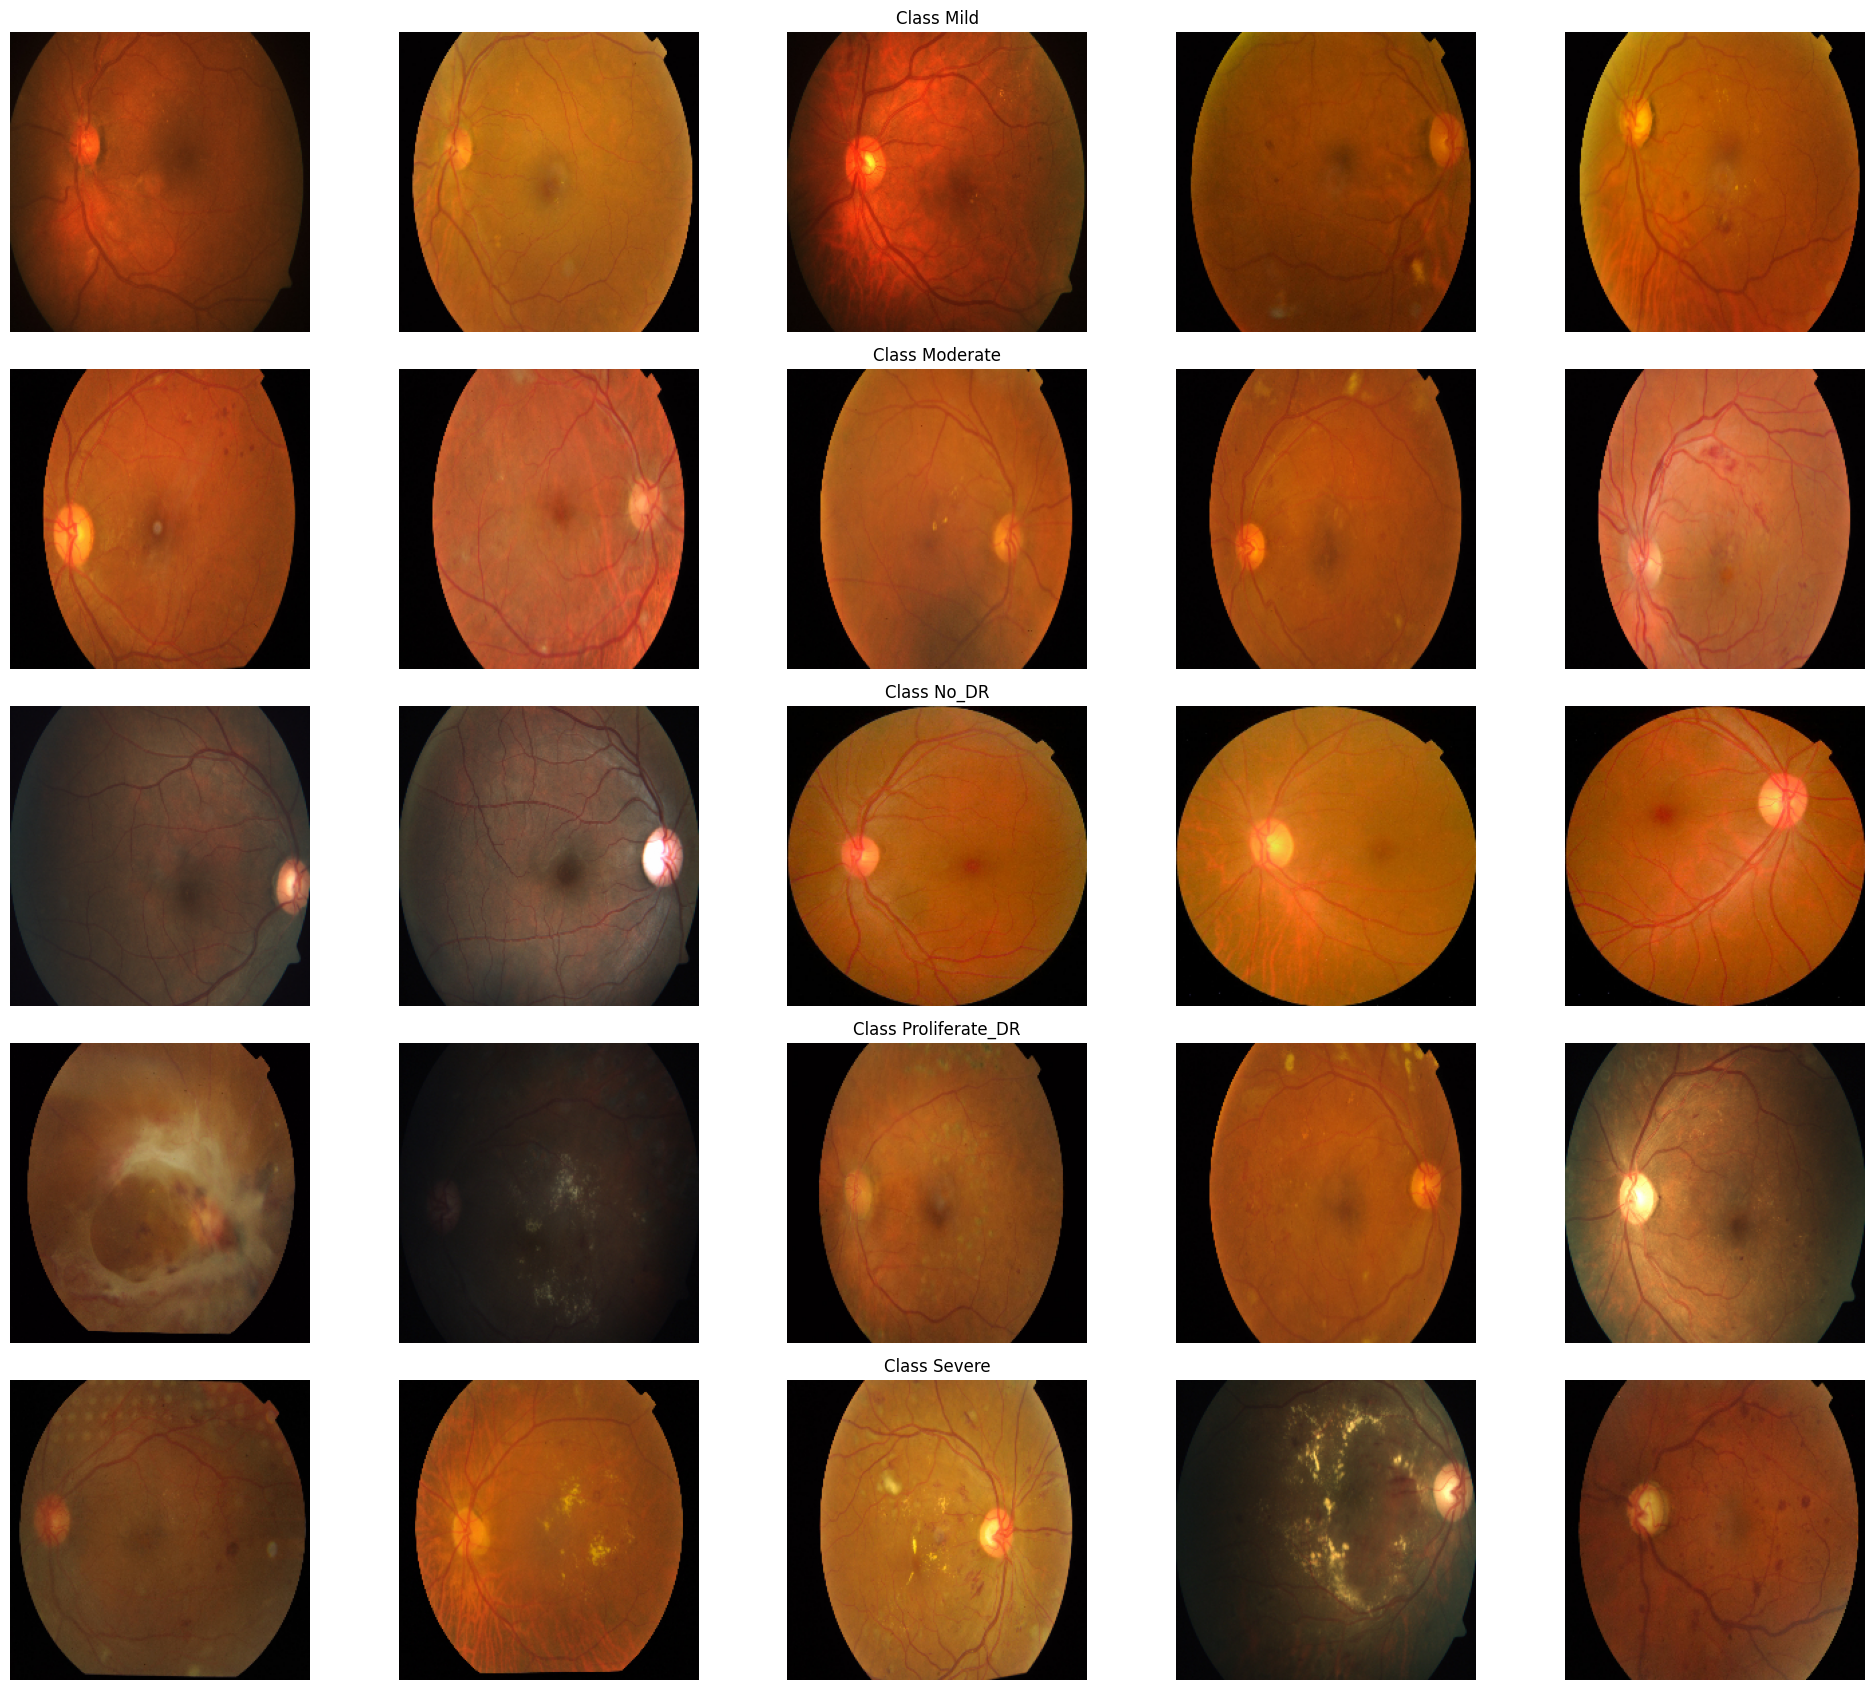

In [5]:

# Buat dictionary berisi daftar gambar tiap kelas
lung_image = {}
for label in os.listdir(dataset_path):
    lung_image[label] = os.listdir(os.path.join(dataset_path, label))

# Menampilkan 5 gambar acak untuk setiap kelas
num_images = 5
num_classes = len(lung_image.keys())
fig, axs = plt.subplots(num_classes, num_images, figsize=(20, 17))

for i, class_name in enumerate(sorted(lung_image.keys(), key=str)):  # urutkan kelas secara numerik
    images = np.random.choice(lung_image[class_name], num_images, replace=False)
    for j in range(num_images):
        img_path = os.path.join(dataset_path, class_name, images[j])
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if j == 2:
            axs[i, j].set_title(f"Class {class_name}")

plt.tight_layout()
plt.show()


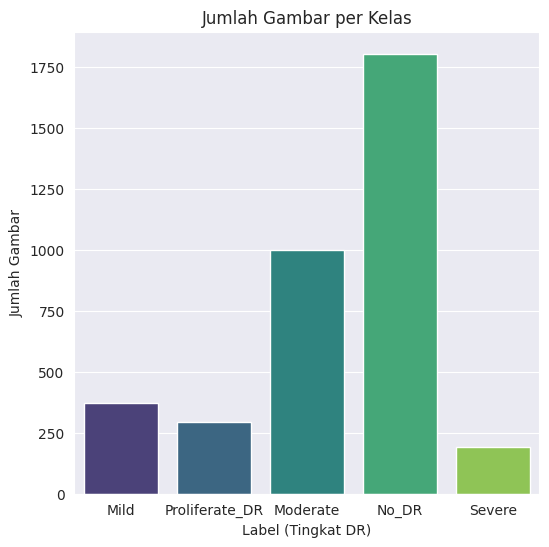

In [6]:
file_name = []
label = []
full_path = []

# Looping file dalam folder dataset_path
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        label.append(path.split('/')[-1])
        file_name.append(name)

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": label
})

# Visualisasi distribusi label
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(x=distribution_train['labels'], palette="viridis")
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Label (Tingkat DR)")
plt.ylabel("Jumlah Gambar")
plt.show()

# **Data Preprocessing**

Augmenting label 'Mild' to reach 1750 images (4 augmentasi per gambar)


Augmenting Mild: 100%|██████████| 370/370 [01:01<00:00,  6.03it/s]


Augmenting label 'Proliferate_DR' to reach 1750 images (5 augmentasi per gambar)


Augmenting Proliferate_DR: 100%|██████████| 295/295 [00:59<00:00,  4.95it/s]


Augmenting label 'Moderate' to reach 1750 images (1 augmentasi per gambar)


Augmenting Moderate: 100%|██████████| 999/999 [01:00<00:00, 16.43it/s]


Copying label 'No_DR' tanpa augmentasi.


Copying No_DR: 100%|██████████| 1805/1805 [00:03<00:00, 529.18it/s]


Augmenting label 'Severe' to reach 1750 images (9 augmentasi per gambar)


Augmenting Severe: 100%|██████████| 193/193 [01:05<00:00,  2.94it/s]


Jumlah gambar per kelas setelah augmentasi:
labels
Moderate          1952
No_DR             1805
Severe            1794
Mild              1749
Proliferate_DR    1666
Name: count, dtype: int64


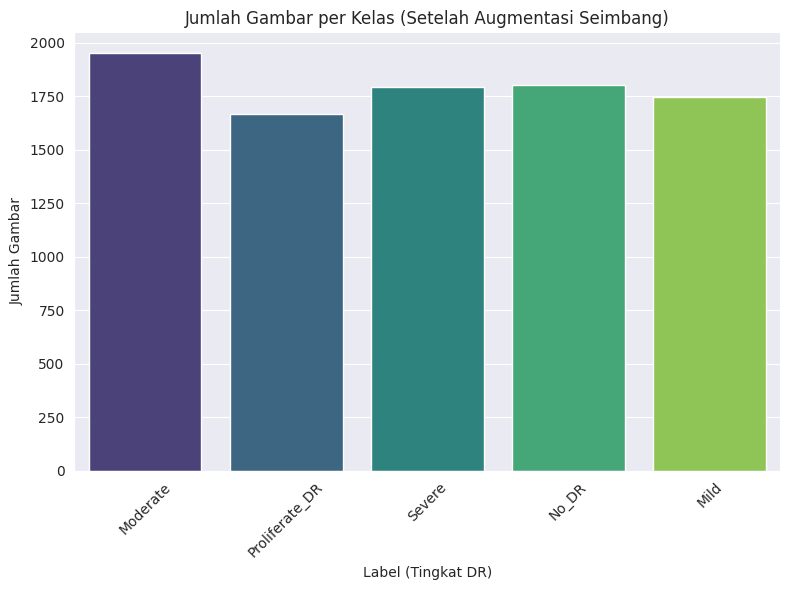

In [30]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Jumlah augmentasi per gambar
aug_per_image = 5  # sesuaikan sesuai kebutuhan

# Buat tiga konfigurasi augmentasi berbeda
datagen_mild = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

datagen_proliferate = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

datagen_severe = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

datagen_moderate = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

source_dir = "/kaggle/input/colored_images"
target_dir = "/kaggle/working/Augmentasi"
os.makedirs(target_dir, exist_ok=True)

# Perbaiki keys supaya semua lowercase
augmentor_map = {
    "mild": datagen_mild,
    "proliferate_dr": datagen_proliferate,
    "severe": datagen_severe,
    "moderate": datagen_moderate  
}

import math

TARGET_COUNT = 1750

# Ubah bagian augmentasi menjadi:
for label in os.listdir(source_dir):
    label_lower = label.lower()
    label_path = os.path.join(source_dir, label)
    save_path = os.path.join(target_dir, label)
    os.makedirs(save_path, exist_ok=True)

    images = [f for f in os.listdir(label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    existing_count = len(images)

    if label_lower in augmentor_map:
        datagen = augmentor_map[label_lower]
        total_to_generate = TARGET_COUNT - existing_count
        aug_per_image = max(1, math.ceil(total_to_generate / existing_count))  # distribusi rata augmentasi

        print(f"Augmenting label '{label}' to reach {TARGET_COUNT} images ({aug_per_image} augmentasi per gambar)")

        for img_name in tqdm(images, desc=f"Augmenting {label}"):
            img_path = os.path.join(label_path, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Augmentasi loop
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_path,
                                      save_prefix='aug', save_format='png'):
                i += 1
                if i >= aug_per_image:
                    break

            # Simpan gambar asli
            original_save_path = os.path.join(save_path, "original_" + img_name)
            if not os.path.exists(original_save_path):
                img.save(original_save_path)

    else:
        print(f"Copying label '{label}' tanpa augmentasi.")
        for img_name in tqdm(images, desc=f"Copying {label}"):
            src = os.path.join(label_path, img_name)
            dst = os.path.join(save_path, img_name)
            if not os.path.exists(dst):
                shutil.copy(src, dst)


# Buat DataFrame hasil akhir
final_paths = []
final_labels = []

for label in os.listdir(target_dir):
    label_folder = os.path.join(target_dir, label)
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file_name)
        if os.path.isfile(file_path):
            final_paths.append(file_path)
            final_labels.append(label)

df = pd.DataFrame({
    'path': final_paths,
    'labels': final_labels
})

print("Jumlah gambar per kelas setelah augmentasi:")
print(df['labels'].value_counts())

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(x="labels", data=df, palette="viridis")
plt.title("Jumlah Gambar per Kelas (Setelah Augmentasi Seimbang)")
plt.xlabel("Label (Tingkat DR)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 999

In [70]:
import os
import shutil
import random
import pandas as pd
from sklearn.model_selection import train_test_split

source_dir = '/kaggle/working/Augmentasi'  # isi awal dataset
base_output = '/kaggle/working/Final_split'  # folder baru untuk hasil split
os.makedirs(base_output, exist_ok=True)

# Buat 3 folder tujuan
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(base_output, split, class_name), exist_ok=True)

# Ambil semua path dan label
all_images = []
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append((os.path.join(class_path, img_file), class_name))

# Shuffle dan pisahkan
trainval, test = train_test_split(all_images, test_size=0.10, stratify=[label for _, label in all_images], random_state=42)
train, val = train_test_split(trainval, test_size=0.1111, stratify=[label for _, label in trainval], random_state=42)  # 0.1111 x 90% ≈ 10%

# Fungsi copy file
def copy_files(data, split_name):
    for src_path, label in data:
        dst_path = os.path.join(base_output, split_name, label, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

copy_files(train, 'train')
copy_files(val, 'val')
copy_files(test, 'test')

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")


Train: 7172, Val: 897, Test: 897


In [71]:

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    base_output + '/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_data = val_test_datagen.flow_from_directory(
    base_output + '/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    base_output + '/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 11441 images belonging to 5 classes.
Found 1661 images belonging to 5 classes.
Found 1669 images belonging to 5 classes.


# **Modeling**

In [78]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

# Loading DenseNet201 model
input_layer = layers.Input(shape=(224, 224, 3))

base_densenet_model = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=input_layer
)
base_densenet_model.trainable = False

# Define densenet_model without data_augmentation
densenet_model = models.Sequential([
    base_densenet_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')
])

densenet_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 64)            │       1,105,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,511,173 (74.43 MB)

 Trainable params: 1,188,805 (4.53 MB)

 Non-trainable params: 18,322,368 (69.89 MB)

In [79]:
densenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


# Fine-tune: Unfreeze bagian akhir DenseNet
for layer in base_densenet_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True


In [80]:

# Latih kembali model
history_fine = densenet_model.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9835']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


358/358 ━━━━━━━━━━━━━━━━━━━━ 151s 282ms/step - accuracy: 0.4307 - loss: 1.5317 - val_accuracy: 0.3986 - val_loss: 2.9438 - learning_rate: 1.0000e-04
Epoch 2/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.6526 - loss: 0.9576 - val_accuracy: 0.7580 - val_loss: 0.7112 - learning_rate: 1.0000e-04
Epoch 3/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7355 - loss: 0.7533 - val_accuracy: 0.7742 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 4/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.7904 - loss: 0.6131 - val_accuracy: 0.7869 - val_loss: 0.6241 - learning_rate: 1.0000e-04
Epoch 5/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.8349 - loss: 0.4984 - val_accuracy: 0.7845 - val_loss: 0.6169 - learning_rate: 1.0000e-04
Epoch 6/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.8713 - loss: 0.4042 - val_accuracy: 0.8224 - val_loss: 0.5085 - learning_rate: 1.0000e-04
Epoch 7/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 144ms/step -

In [81]:
# Evaluasi di data test
loss, acc = densenet_model.evaluate(test_data)
print(f"Akurasi Test Set: {acc:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9316 - loss: 0.2314
Akurasi Test Set: 0.9425


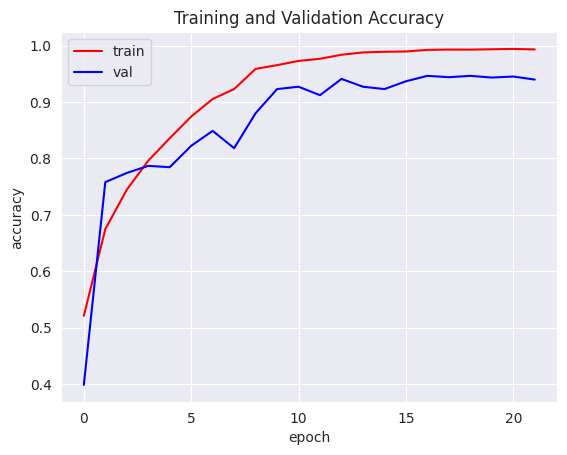

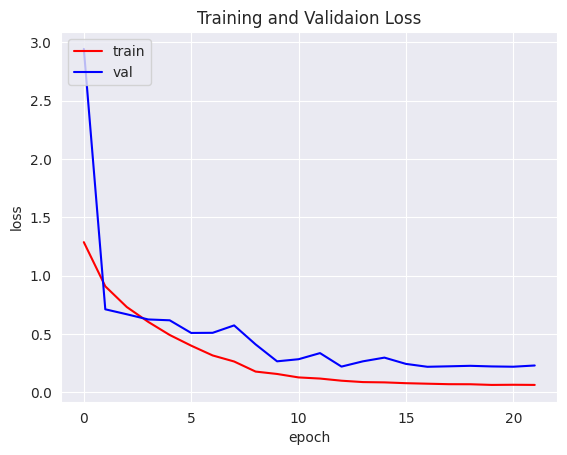

In [82]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9835']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step
                precision    recall  f1-score   support

          Mild       0.91      0.96      0.93       349
      Moderate       0.93      0.85      0.89       295
         No_DR       1.00      0.99      1.00       343
Proliferate_DR       0.94      0.92      0.93       326
        Severe       0.93      0.98      0.95       356

      accuracy                           0.94      1669
     macro avg       0.94      0.94      0.94      1669
  weighted avg       0.94      0.94      0.94      1669



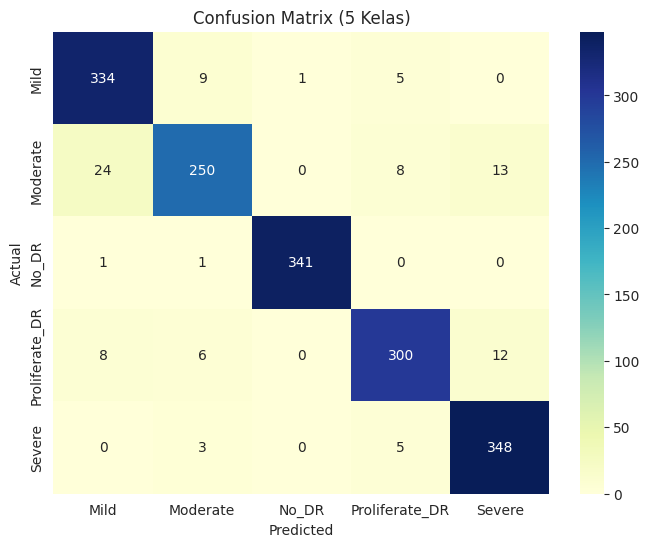

In [83]:
preds_1 = densenet_model.predict(test_data)

# Ambil prediksi kelas (0 atau 1) dari output softmax
pred_labels = np.argmax(preds_1, axis=1)

# Ambil label asli
true_labels = test_data.classes

# Nama label (opsional, disesuaikan dengan klasemu)
label_names = list(test_data.class_indices.keys()) 

# Cetak classification report
report = classification_report(true_labels, pred_labels, target_names=label_names)
print(report)

# Konversi dari probabilitas ke label
pred_labels = np.argmax(preds_1, axis=1)

# Buat confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (5 Kelas)")
plt.show()


# **Save Model**

In [84]:
densenet_model.save('model-Retinopaty-Diabetic.h5')

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


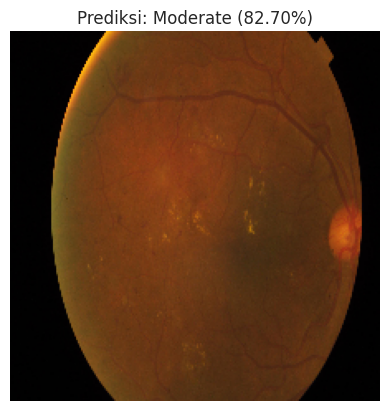

In [89]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- Ganti sesuai lokasi file yang sudah kamu upload ---
img_filename = '/kaggle/input/colored_images/Moderate/000c1434d8d7.png'  # <- sesuaikan

# Ukuran gambar yang dipakai saat training
IMAGE_SIZE = (224, 224)

# Load dan resize gambar
img = load_img(img_filename, target_size=IMAGE_SIZE)
img_array = img_to_array(img)

# Preprocessing sesuai DenseNet
img_batch = np.expand_dims(img_array, axis=0)
img_batch = tf.keras.applications.densenet.preprocess_input(img_batch)

# Load model
densenet_model = tf.keras.models.load_model('/kaggle/working/model-Retinopaty-Diabetic.h5')

# Prediksi
predictions = densenet_model.predict(img_batch)
predicted_class = np.argmax(predictions[0])

# Ambil confidence/probabilitas dari prediksi
confidence = np.max(predictions[0]) * 100  # dalam persen

# Ambil label kelas
class_labels = list(train_data.class_indices.keys())  # pastikan train_data tersedia
predicted_label = class_labels[predicted_class]

# Tampilkan gambar dan hasil prediksi
plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Prediksi: {predicted_label} ({confidence:.2f}%)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


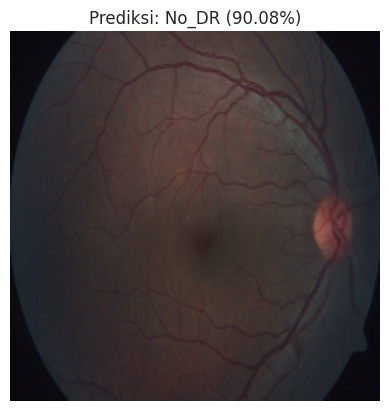

In [90]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- Ganti sesuai lokasi file yang sudah kamu upload ---
img_filename = '/kaggle/input/colored_images/No_DR/0097f532ac9f.png'  # <- sesuaikan

# Ukuran gambar yang dipakai saat training
IMAGE_SIZE = (224, 224)

# Load dan resize gambar
img = load_img(img_filename, target_size=IMAGE_SIZE)
img_array = img_to_array(img)

# Preprocessing sesuai DenseNet
img_batch = np.expand_dims(img_array, axis=0)
img_batch = tf.keras.applications.densenet.preprocess_input(img_batch)

# Load model
densenet_model = tf.keras.models.load_model('/kaggle/working/model-Retinopaty-Diabetic.h5')

# Prediksi
predictions = densenet_model.predict(img_batch)
predicted_class = np.argmax(predictions[0])

# Ambil confidence/probabilitas dari prediksi
confidence = np.max(predictions[0]) * 100  # dalam persen

# Ambil label kelas
class_labels = list(train_data.class_indices.keys())  # pastikan train_data tersedia
predicted_label = class_labels[predicted_class]

# Tampilkan gambar dan hasil prediksi
plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Prediksi: {predicted_label} ({confidence:.2f}%)")
plt.show()